In [1]:
"""
Code to check on the monthly amt pCO2 trend for future projection

source from https://doi.org/10.5194/gmd-13-3571-2020

download from https://greenhousegases.science.unimelb.edu.au/#!/view

"""


'\nCode to check on the monthly amt pCO2 trend for future projection\n\nsource from https://doi.org/10.5194/gmd-13-3571-2020\n\ndownload from https://greenhousegases.science.unimelb.edu.au/#!/view\n\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import datetime

from lo_tools import plotting_functions as pfun
from lo_tools import Lfun
Ldir = Lfun.Lstart()


In [3]:
#  read data using xarray

fod = 'projection'
source = 'pCO2'
in_file = Ldir['data'] / fod / source / 'air'/'mole-fraction-of-carbon-dioxide-in-air_input4MIPs_GHGConcentrations_ScenarioMIP_UoM-MESSAGE-GLOBIOM-ssp245-1-2-1_gr1-GMNHSH_201501-250012.nc'

df0 = xr.open_dataset(in_file)

# convert data to datetime format
date = pd.to_datetime([t.strftime('%Y-%m-%d') for t in df0['time'][0:1021].values])
# read CO2 data
co2 = df0['mole_fraction_of_carbon_dioxide_in_air'][0:1021,1].values
time = date.to_numpy()

In [4]:
"""
here we create a increasing curve, with decaying slope rate
"""

pi2 = 6.2831853071796
D0 = 400

D1 = 0.22  # how slopy it is

D2 = 7.25 # amplitude

#D3 = -0.5
D3 = 0.4

D4 = -0.99
D5 = 0.28

D6 = 0
D7 = 0

# slope_rate = 0.00131 # Rate of increase in the slope
slope_rate = 0.001 # Rate of increase in the slope

start_year = 2015 # note to change it to 1958 
decay_constant = 0.12  # Controls how quickly the slope decreases (adjustable)

# Create the date range
dti = pd.date_range(start='2015-01-01', end='2100-01-31', freq='D')
pmonth = dti.year - 2015.0 + dti.dayofyear / 365.0

# Logistic decay for slope rate
year_offset = (dti.year - 2070).to_numpy()
# year_offset = dti.year - 2070
slope_rate_adjusted = slope_rate / (1 + np.exp(decay_constant * year_offset))

# Updated pCO2 air secular equation
pCO2air_secular_future = (
        D0
        + (D1 + slope_rate_adjusted * (dti.year - start_year)) * pmonth * 12.0
        + D2 * np.sin(pi2 * pmonth + D3)
        + D4 * np.sin(pi2 * pmonth + D5)
        + D6 * np.sin(pi2 * pmonth + D7)
)

"""
after 2085, it follow logistic growth curve
"""
# Modify the equation for years after 2085
pCO2air_secular_future = pCO2air_secular_future.to_numpy()

mask = dti.year > 2085

if mask.any():
    N0 = 320
    K = np.max(co2)  # Update D0 with max value, this is the upper bound
    pCO2air_secular_future[mask] = (
            K
            / (1 + np.exp(-32 * (dti.year[mask] - start_year) / K) * (K / N0 - 1))
            + D2 * np.sin(pi2 * pmonth[mask] + D3)
            + D4 * np.sin(pi2 * pmonth[mask] + D5)
            + D6 * np.sin(pi2 * pmonth[mask] + D7)
    )


s = pd.Series(index=dti, data=pCO2air_secular_future)

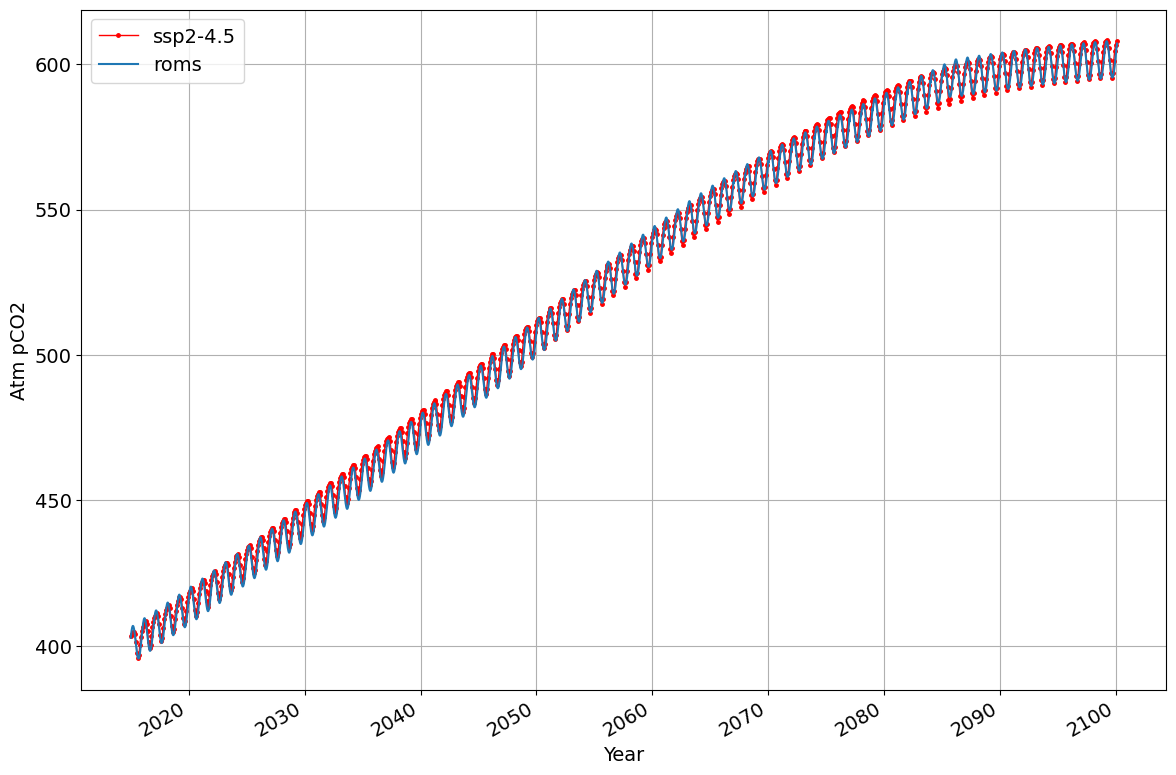

In [5]:
# plot SSP2-4.5 

plt.close('all')
pfun.start_plot()
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(time, co2, c='red',marker='.',markersize = 5, linestyle='-', linewidth=1)
s.plot(ax=ax)
ax.grid(True)
ax.set_xlabel('Year')
ax.set_ylabel('Atm pCO2')
ax.legend(labels=['ssp2-4.5','roms'], loc = 'upper left')

# fig_dir = Ldir['LOo'] / 'plots'/source
# fig.savefig(f'{fig_dir}/pCO2_Obs_ROMS_after.png', bbox_inches='tight')
plt.show()

In [6]:
# plot the historical from Scripps 
v_dict = {
    '  Yr': 'year',
    ' Mn': 'month',
    '    Date': 'Date_excel',
    '      Date': 'Date',
    '     CO2': 'CO2 (ppm)',
    'seasonally': 'CO2_seasonally_adjusted (ppm)',
    '        fit': 'CO2_fit (ppm)',
    '  seasonally': 'CO2_seasonally_adjusted_fit (ppm)',
    '      CO2': 'CO2_filled (ppm)',
    ' seasonally': 'CO2_seasonally_adjusted_filled (ppm)',
    ' Sta': 'station'
}

in_file = Ldir['data'] / 'obs' / source / 'air'/'monthly_in_situ_co2_mlo.csv'

df = pd.read_csv(in_file, skiprows=61, usecols=list(v_dict.keys()))
df.rename(columns=v_dict, inplace=True)
df = df.drop([0, 1])
df = df.reset_index(drop=True)
df['day'] = 15
df = df.apply(pd.to_numeric, errors='coerce')
# missing data is -99.99
df[df == -99.99] = np.nan
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day']])


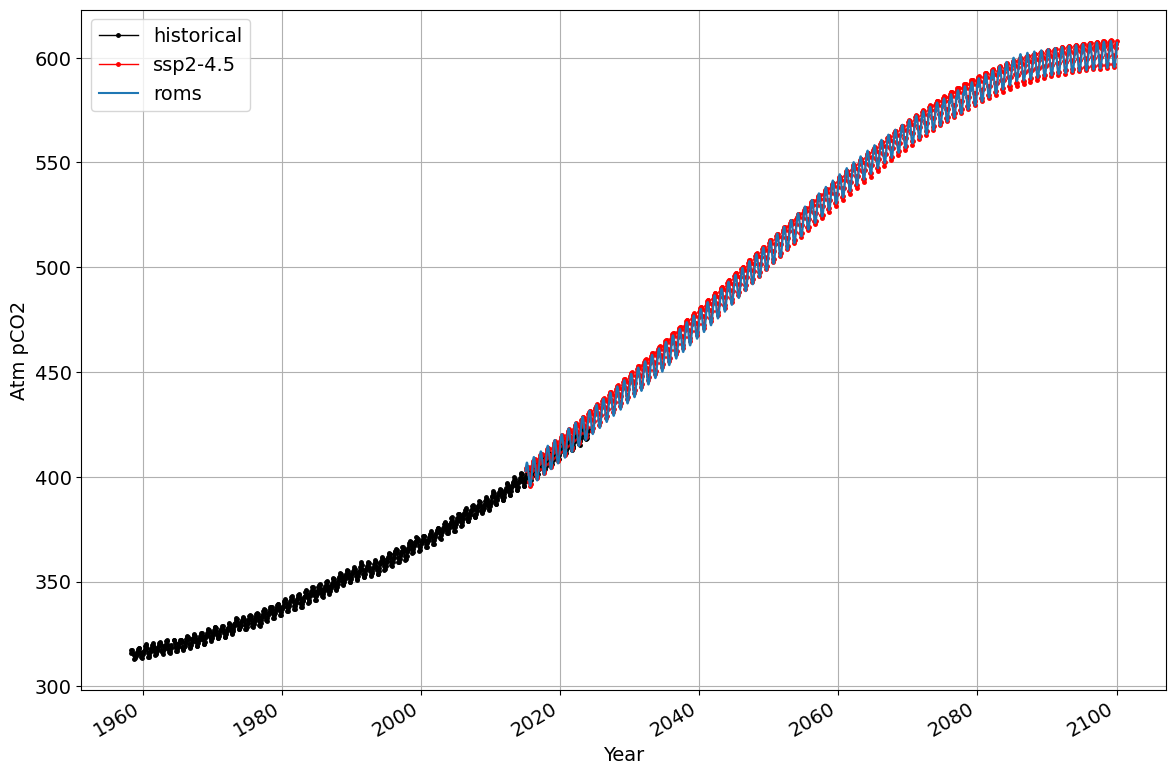

In [7]:

plt.close('all')
pfun.start_plot()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df['datetime'].values, df['CO2 (ppm)'].values, c='black',marker='.',markersize = 5, linestyle='-', linewidth=1)
ax.plot(time, co2, c='red',marker='.',markersize = 5, linestyle='-', linewidth=1)
s.plot(ax=ax)
ax.grid(True)
ax.set_xlabel('Year')
ax.set_ylabel('Atm pCO2')
ax.legend(labels=['historical','ssp2-4.5','roms'], loc = 'upper left')

fig_dir = Ldir['LOo'] / 'plots'/ source
Lfun.make_dir(fig_dir)
fig.savefig(f'{fig_dir}/pCO2_histotical_ssp2-4.5.png', bbox_inches='tight')

plt.show()


